### Bio Clustering (Word2Vec and Kmeans Clustering)

In [2]:
import pandas as pd
import numpy as np
from time import time
import re
import os
import nltk
import gensim.models.word2vec as w2v

nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import multiprocessing

import seaborn as sns
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import sklearn.manifold

from  sklearn.cluster import KMeans
import glob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading file and creating dataframe

In [3]:
file = os.listdir("_data/unlabled/")
file

['bio_1501672304.9134998.txt',
 'bio_1501694930.6841238.txt',
 'bio_1501598612.022413.txt',
 'bio_1501693740.803672.txt']

In [4]:
all_data = []
for i in file:
    with open("_data/unlabled/{}".format(i)) as f:
        temp_data = f.read().split('\n')
    all_data.extend(temp_data)

In [5]:
def clean_sentence(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

In [6]:
df = pd.DataFrame(all_data, columns=['bio'])
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()

df = pd.DataFrame(df['bio'].apply(clean_sentence))
df.drop_duplicates(inplace=True)
df.count()

bio    44440
dtype: int64

#### Data Details

In [7]:
df.describe()

,bio
count,44440
unique,44440
top,German speaking island woman affinities public...
freq,1


In [8]:
df['word_freq'] = df['bio'].apply(lambda x: len(x.split()))

#### Average sentence length

In [9]:
df['word_freq'].mean()

10.326597659765977

### Word2Vec Feature Extraction

In [10]:
def sentence_to_wordlist(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text.lower())
    return tokens

In [11]:
sentences = []
for raw_sentence in df['bio']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [12]:
sentences[909]

['artist', 'voice', 'voiceless']

In [13]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 459,007 tokens


**Word2Vec model**



In [14]:
# Dimensionality of the resulting word vectors.
# more dimensions mean more training them, but more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3
# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7
# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3
# Seed for the RNG, to make the results reproducible.
seed = 1

In [15]:
t0 = time()
bio_vec = w2v.Word2Vec(
    sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    iter = 10
)

print("Train Time:", time()-t0)

Train Time: 62.199732065200806


In [16]:
if not os.path.exists("_data/trained"):
    os.makedirs("_data/trained")

bio_vec.save(os.path.join("_data/trained", "bioVectors.w2v"))

In [17]:
bio_vec.most_similar_cosmul("machine")

[('neural', 0.9214475750923157),
 ('ml', 0.9190054535865784),
 ('learning', 0.9159418940544128),
 ('algorithms', 0.9153146743774414),
 ('machines', 0.912142813205719),
 ('ai', 0.9044017791748047),
 ('computational', 0.903572678565979),
 ('artificial', 0.895260214805603),
 ('visualization', 0.8931264877319336),
 ('machinelearning', 0.8921968936920166)]

In [18]:
print("Vocab Size:", len(bio_vec.wv.vocab.keys()))

Vocab Size: 13684


### Visualization and word-D-reduction

In [25]:
t1 = time()
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = bio_vec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
print("Dimension reduction Time:", time()-t1)

MemoryError: 

In [26]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[bio_vec.wv.vocab[word].index])
            for word in bio_vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

NameError: name 'all_word_vectors_matrix_2d' is not defined

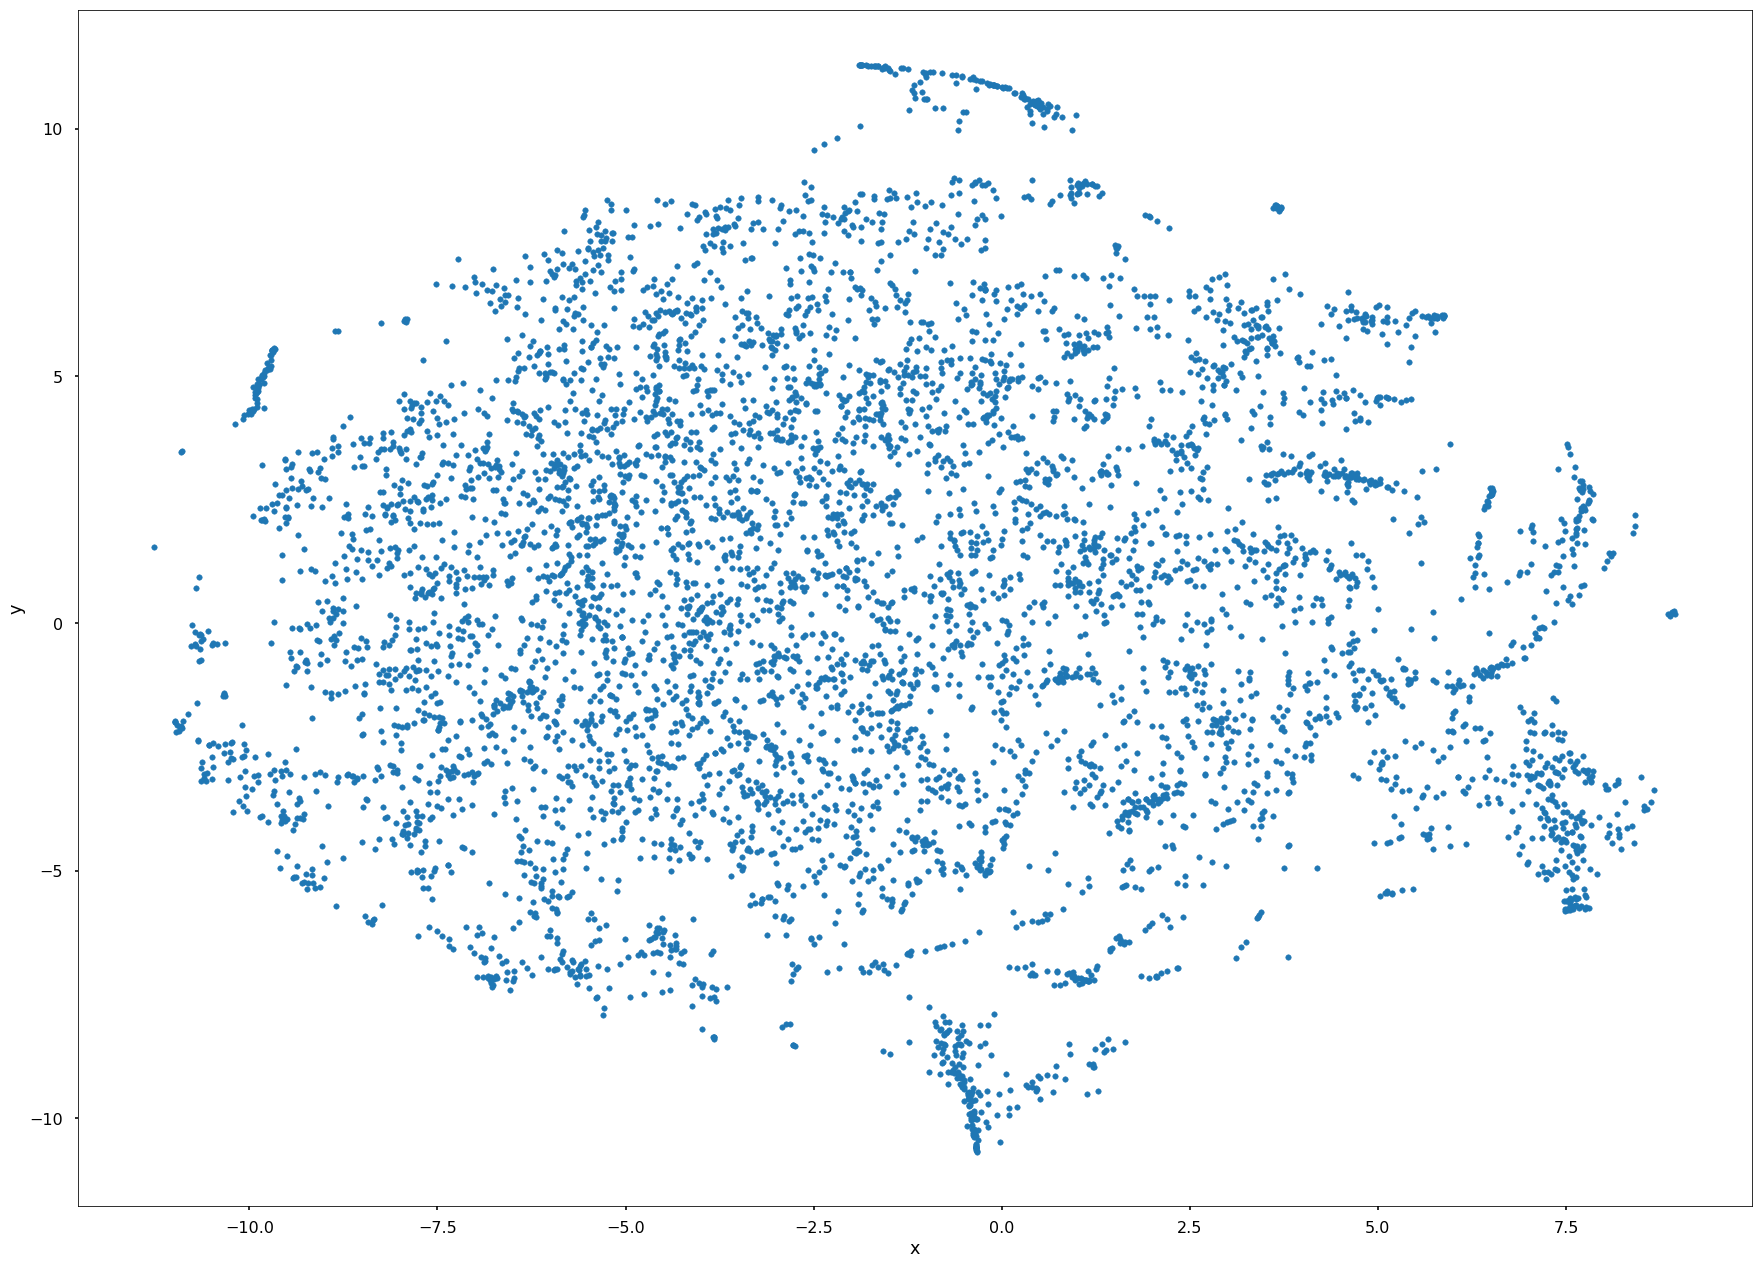

In [29]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=30, figsize=(30, 22))
plt.show()

In [30]:
def plot_region(x_bounds, y_bounds):
    try:
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]

        ax = slice.plot.scatter("x", "y", s=90, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    except:
        print("No word in this region")

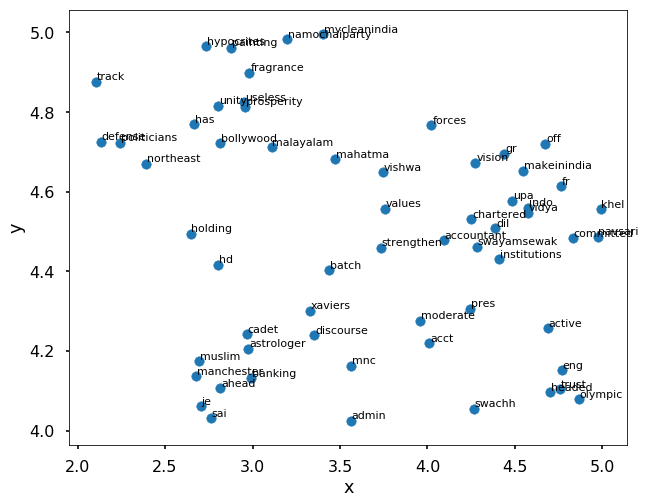

In [37]:
plot_region(x_bounds=(2, 5), y_bounds=(4, 5))

plt.show()

### Sentence Embedding and Clustering

In [19]:
def preprocess_text(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|
                [a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+
                (?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    tokens = word_tokenize(raw.lower())
    return tokens

In [19]:
def embed_sentences(s):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    for t in sample_text_tokens:
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, bio_vec[t]])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [20]:
sentence_vectors = np.array([]).reshape(0, 2)

for index, row in df.iterrows():
    sentence_vectors = np.vstack([sentence_vectors, embed_sentences(row['bio'])])

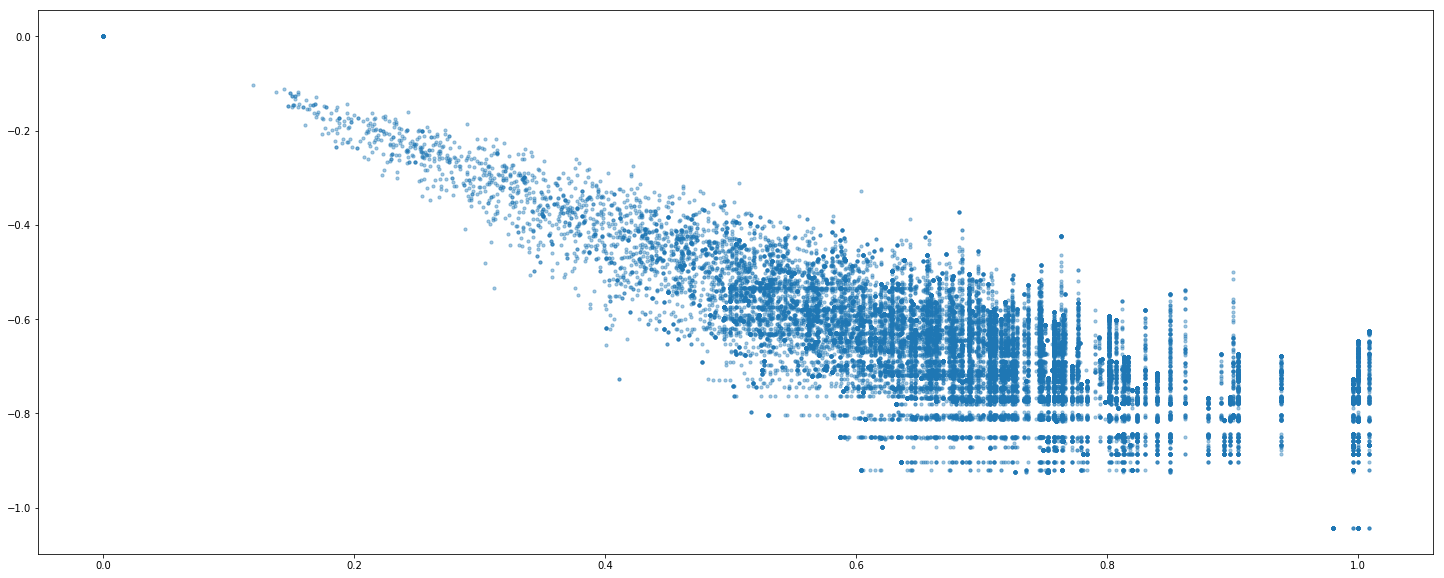

In [21]:
plt.figure(figsize=(25, 10))
plt.scatter([i[0] for i in sentence_vectors], [i[1] for i in sentence_vectors], s=10, alpha=0.4)
plt.show()

In [22]:
def kmeans(data, clus):
    km = KMeans(n_clusters=clus, init='k-means++', max_iter=1000, n_init=1,
                    verbose=False)

    print("Clustering sparse data with %s" % km)
    t0 = time()
    km.fit(data)
    print("done in %0.3fs" % (time() - t0))

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1


    plt.figure(figsize=(25, 10))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.4)

    # Plot the centroids as a white X
    centroids = km.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=90, linewidths=1,
                color='r')
    plt.title('K-means clustering')
    plt.show()
    return km

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.102s


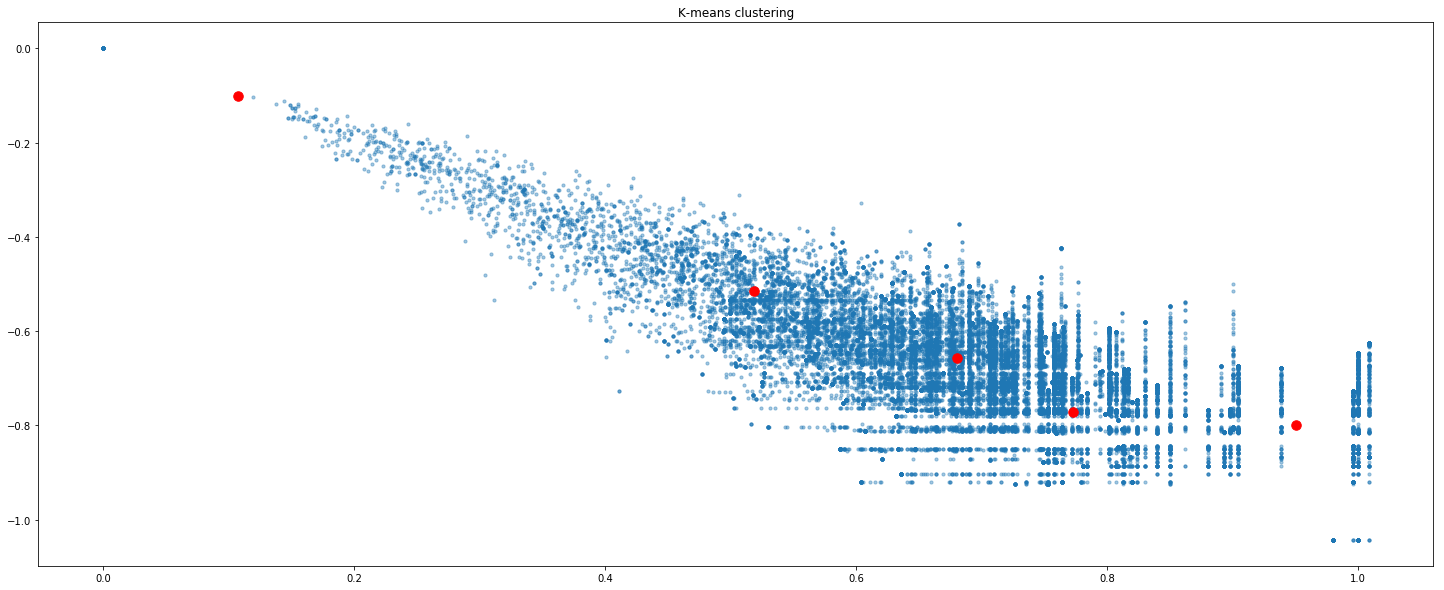

In [23]:
kmean_w2v = kmeans(sentence_vectors, 5)

In [24]:
clusters = {i: df['bio'][np.where(kmean_w2v.labels_ == i)[0]] for i in range(kmean_w2v.n_clusters)}

In [25]:
clusters[3]

1        Growing commerce India Flipkart Passionate bui...
5        Official eBay India Feed Watch space company a...
7        Stay connected Flipkart Seller Hub account ded...
9        Official account news stories Flipkart tech bo...
11       We tweet technology Technology use technology ...
12       Official account news stories culture happenin...
13                           Co founder CEO Flipkart Group
17       Indian techie optimist entrepreneurial believe...
18                        Co founder Engineer proud Indian
25       For day job Salesforce I write code machines B...
33       LinkedIn India Head Pulse Co founder Stanford ...
34       Ather Energy start building India first Smart ...
35                  technology music jokes anything stupid
36                              Co founder CEO AtherEnergy
38       Writer Comedian Desi Kalakaar Loud Indian Book...
40       Writer Comic Podcaster YouTuber Co Founder All...
43       I dig variety acts Pixar puppets prestidigitat.

### Word2Vec + TfIDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=300,
                                 min_df=2, stop_words='english',
                                 use_idf=True)

TfX = vectorizer.fit_transform(df['bio'])

In [28]:
feature_names = vectorizer.get_feature_names()
def get_tfidf_weight(doc):
    feature_index =TfX[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [TfX[doc, x] for x in feature_index])
    result = {}
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        result[w] = s
    return result

In [29]:
get_tfidf_weight(100)

{'culture': 0.63859712849633621,
 'tech': 0.5483881130490118,
 'views': 0.53987423067116092}

In [30]:
def embed_sentences_tfidf_weight(s, doc):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    word_weights = get_tfidf_weight(doc)
    vector_weight = 1
    for t in sample_text_tokens:
        if t in word_weights:
            vector_weight = word_weights[t]
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, np.add(vector_weight, bio_vec[t])])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [31]:
sentence_vectors_tf = np.array([]).reshape(0, 2)

i = 0
for index, row in df.iterrows():
    sentence_vectors_tf = np.vstack([sentence_vectors_tf, embed_sentences_tfidf_weight(row['bio'], i)])
    i+=1

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=8, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.374s


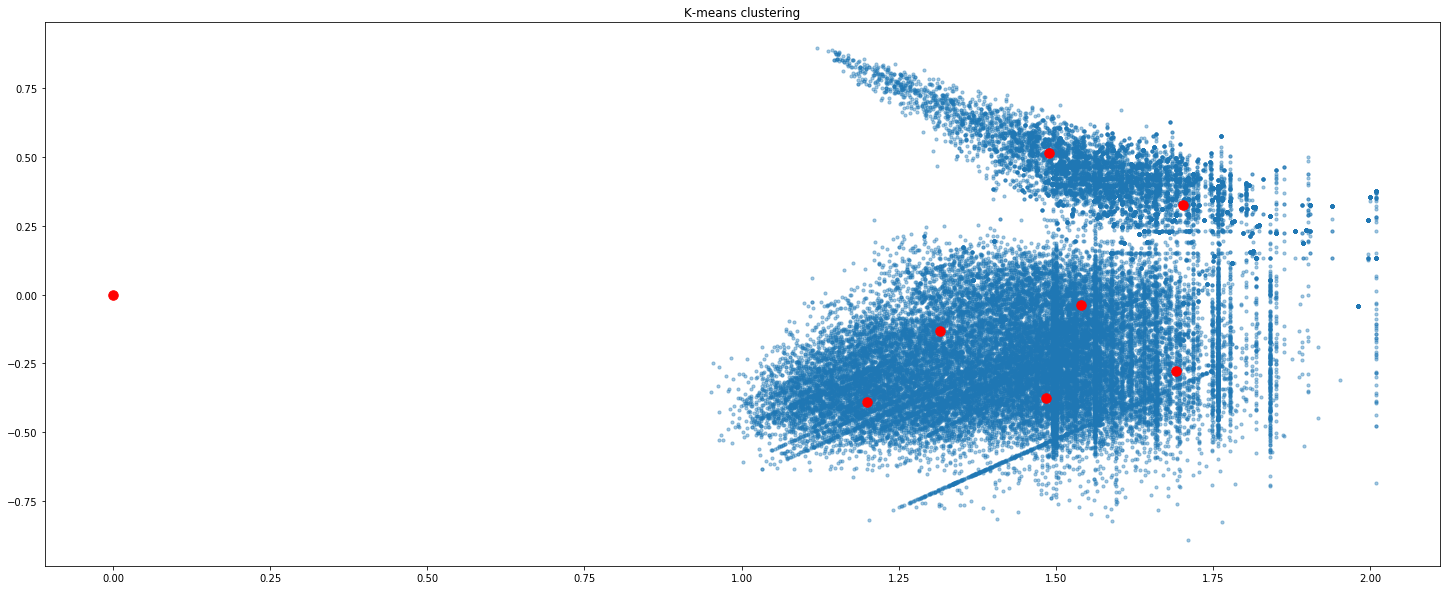

In [37]:
kmean_tfidf_w2v = kmeans(sentence_vectors_tf, 8)

In [38]:
clusters_tfidf = {i: df['bio'][np.where(kmean_tfidf_w2v.labels_ == i)[0]] for i in range(kmean_tfidf_w2v.n_clusters)}

In [39]:
clusters_tfidf[3]

17       Indian techie optimist entrepreneurial believe...
28       SF Seattle India Photography Running Best part...
32                                   Internet entrepreneur
38       Writer Comedian Desi Kalakaar Loud Indian Book...
46       tweets Anderson Cooper Anchor AC correspondent...
59                   Actor Believer Aspiring time traveler
60       Sikhya Entertainment fulltime dreamer n Produc...
64       Members daily updates Stratechery Free full le...
65                           Social media support Flipkart
72       Technology billion Indians IndiaStack set open...
73       Journalist Economic Times Views expressed pers...
75       India First Most Extensive Data Journalism Ini...
80               Hospitality Logistics Travel Ecomm Retail
82                                                     NaN
84       Flipkart Ads end end commerce advertising solu...
85       Chief Architect Aadhaar Architect India Stack ...
90                                                     O

### Word2Vec + ResultantVec

In [40]:
a = bio_vec['verge']
b = bio_vec['reporter']

In [41]:
np.divide(np.add(a, b), 2)

array([ -1.12103671e-01,  -9.21854675e-02,  -2.86784172e-01,
         2.71446556e-01,   1.69647068e-01,   3.14711183e-02,
         1.38510078e-01,   9.79248881e-02,   2.76219666e-01,
         8.44953954e-02,   3.98163676e-01,   3.14709336e-01,
         1.59216635e-02,  -7.76237398e-02,  -4.78097498e-02,
        -2.04591423e-01,   8.39746073e-02,  -4.76513058e-02,
        -1.51798904e-01,   6.03993870e-02,  -1.81851164e-02,
         9.28338915e-02,  -2.63514742e-02,  -5.94931394e-02,
        -1.08747240e-02,  -2.08430022e-01,   1.26225382e-01,
        -1.26041695e-02,   2.96458341e-02,  -2.93155998e-01,
        -3.19570303e-01,  -1.70441031e-01,   3.58381212e-01,
        -7.48807117e-02,   1.12359539e-01,   3.00422043e-01,
         1.69775963e-01,   1.25554383e-01,  -3.40216696e-01,
        -2.01109245e-01,  -3.80445629e-01,   2.55063325e-01,
        -6.34847134e-02,  -5.41756526e-02,   1.55498669e-01,
        -1.42326877e-01,  -2.35792354e-01,  -1.15806609e-01,
         2.78842688e-01,

In [42]:
def embed_sentences_resultant(s):
    text_tokens = preprocess_text(s)
    word_vectors = np.zeros(300,)
    v_words = 0
    for t in text_tokens:
        if t in bio_vec.wv.vocab.keys():
            v_words+=1
            word_vectors = np.add(word_vectors, bio_vec[t])
    if len(word_vectors):
        return np.divide(word_vectors, v_words)
#         return word_vectors
    else:
        return [0, 0]

In [43]:
embed_sentences_resultant("hello").max()

0.48666712641716003

In [44]:
sentence_vectors_resultant = np.array([]).reshape(0, 2)

for index, row in df.iterrows():
    s_vec = embed_sentences_resultant(row['bio'])
    sentence_vectors_resultant = np.vstack([sentence_vectors_resultant, [s_vec.max(), s_vec.min()] ])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [45]:
sentence_vectors_resultant = pd.DataFrame(sentence_vectors_resultant)
sentence_vectors_resultant.fillna(0, inplace=True)
sentence_vectors_resultant = np.array(sentence_vectors_resultant)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=8, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.221s


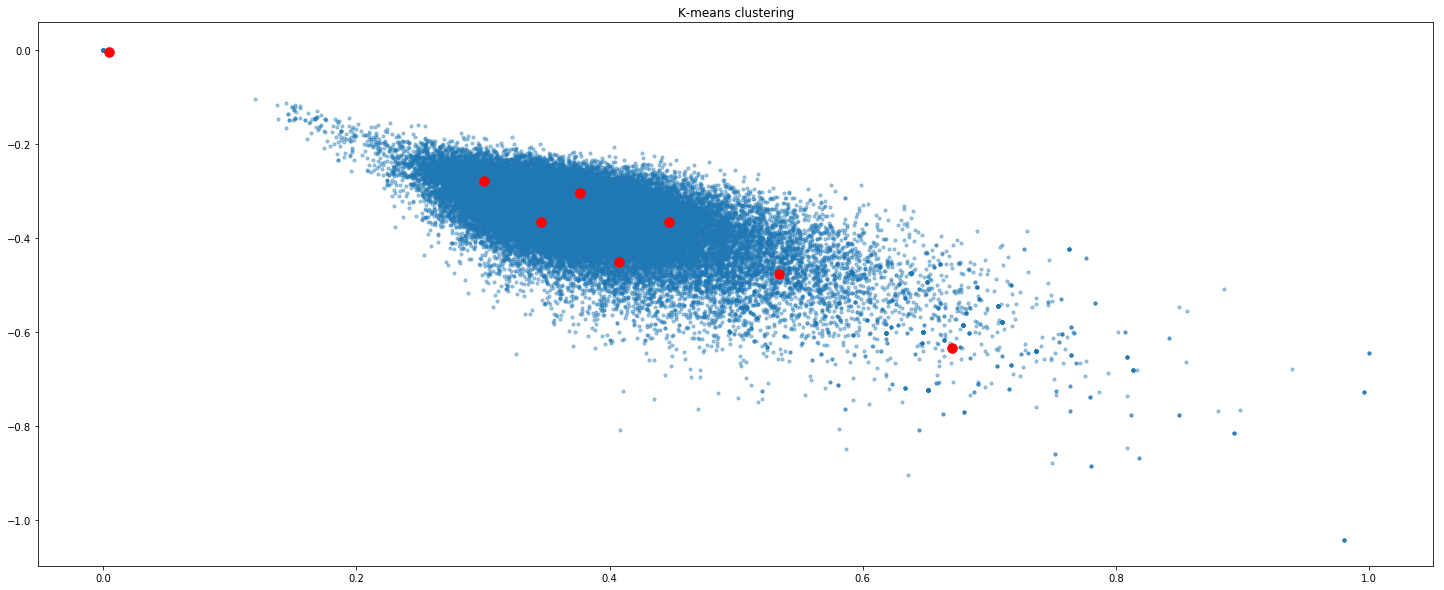

In [46]:
kmean_result = kmeans(sentence_vectors_resultant, 8)

In [47]:
clusters_res = {i: df['bio'][np.where(kmean_result.labels_ == i)[0]] for i in range(kmean_result.n_clusters)}

In [48]:
clusters_res[0]

0        The book PanamaPapers b obermayer f obermaier ...
17       Indian techie optimist entrepreneurial believe...
19       A wannabe perfectionist erroneous reality Pass...
27              Current serving CEO Dr Ajay Bhushan Pandey
28       SF Seattle India Photography Running Best part...
29       CEO Myntra Jabong Ex McKinsey Working intersec...
30       Poet Journalist Editor Parliamentarian Founder...
45                                      planet outer space
46       tweets Anderson Cooper Anchor AC correspondent...
49       Comedian talk show host ice road trucker My tw...
54       Harley Davidson Triumph Ducati Kawasaki Benell...
56       Professor HarvardHBS Author CompetingvsLuck Co...
58       Jon Kabat Zinn created Mindfulness Based Stres...
60       Sikhya Entertainment fulltime dreamer n Produc...
68                                        Chal bhaag saala
71       Charles Francis HuffPost blogger author Mindfu...
72       Technology billion Indians IndiaStack set open.

#### Saving Clusters Data

In [55]:
def save_clusters(cluster_t, cluster_name):
    if not os.path.exists("_data/{}".format(cluster_name)):
        os.makedirs("_data/{}".format(cluster_name))
    path = "_data/{}/".format(cluster_name)
    for i,c in enumerate(cluster_t):
        with open(path+str(i), 'a') as f:
            for t in cluster_t[c]:
                f.write(str(t))
                f.write('\n')
            f.close()
    print("Saved {}".format(cluster_name))

In [56]:
save_clusters(clusters_res, "cluster_res")

Saved cluster_res


In [57]:
save_clusters(clusters_tfidf, "cluster_tfidf")

Saved cluster_tfidf
